In [1]:
import os
import re
import string
import pandas as pd
import torch
import librosa
import numpy as np
from transformers import Wav2Vec2FeatureExtractor, WavLMForXVector, Wav2Vec2ForXVector, Wav2Vec2Processor,AutoFeatureExtractor 

### Processing data, renaming the data in each folder to the same format

In [ ]:
# Process BEST
def process_best(best_path, source='BEST'):
    # load the data summary in from csv file.
    data_summary_df = pd.read_excel(os.path.join(best_path, 'BEST_datasummary.xlsx'))
    emotion_mapping = {}

    for index, row in data_summary_df.iterrows():
        # get the emotion and speaker id
        emotion, speaker_id = row['Emotion'], row['S-ID']

        emotion_mapping[str(speaker_id)] = emotion
    # rename files into the rule format: <source>_<speakerid>_<label>.wav

    # get all files in the directory
    files = os.listdir(best_path)

    # iterate through all files
    source = 'BEST'
    for filename in files:
        if filename.endswith('.wav'): 
            speaker_id, extension = filename.split('.')

            if speaker_id not in emotion_mapping:
                break
            emotion_label = emotion_mapping[speaker_id] # get the emotion label

            # rename the file
            new_filename = f'{source}_{speaker_id}_{emotion_label}' + '.' + extension
            os.rename(os.path.join(best_path, filename), os.path.join(best_path, new_filename))

In [ ]:
# Process EMOGIB
def process_emogib(emogib_path, source='EMOGIB'):
    # filename: <emotion>_"EX"_<audio_type>_<language>_<speakerid>.wav
    # to be renamed to: <source>_<speakerid>_<emotion>_<audio_type>.wav
    emotion_decoding = {
        'ANG': 'anger',
        'DSG': 'disgust',
        'FEA':'fear',
        'JOY': 'happiness',
        'NEU': 'neutral',
        'SAD': 'sadness',
        'SRP':'surprise'
    }
    files = os.listdir(emogib_path)
    for file in files:
        if file.endswith('.wav'):
            filename, extension = file.split('.')

            emotion,_,audio_type,_,speaker_id = filename.split('_')
            # rename the file

            new_filename = f'{source}_{speaker_id}_{emotion_decoding[emotion]}_{audio_type}' + '.' + extension

            

In [ ]:
#Process Lima
def process_lima(lima_path, source='LIMA'):
    # filename: <emotion>_<audio_type>_<speakerid>.wav
    # to be renamed to: <source>_<speakerid>_<emotion>_<audio_type>.wav
    files = os.listdir(lima_path)
    for file in files:
        if file.endswith('.wav'):
            filename, extension = file.split('.')

            emotion, audio_type, speaker_id = filename.split('_')
            # rename
            new_filename = f'{source}_{speaker_id}_{emotion}_{audio_type}' + '.' + extension
            os.rename(os.path.join(lima_path, file), os.path.join(lima_path, new_filename))

In [ ]:
def process_montreal(montreal_path, source='MONTREAL'):
    # filename: <speakerid>_<emotion>_<speaker_type>.wav
    # to be renamed to: <source>_<category>_<speakerid>_<emotion>_<speaker_type>.wav

    files = os.listdir(montreal_path)
    for file in files:
        if file.endswith('.wav'):
            filename, extension = file.split('.')
            # rename
            new_filename = f'{source}_{filename}' + '.' + extension
            os.rename(os.path.join(montreal_path, file), os.path.join(montreal_path, new_filename))


In [ ]:
print(os.getcwd())

# best_path = os.path.join(os.getcwd(), 'embed_recordings','sources','BEST', 'wav')
# process_best(best_path)

# emogib_path = os.path.join(os.getcwd(), 'embed_recordings','sources','EMOGIB', 'wav')
# process_emogib(emogib_path)

# lima_path = os.path.join(os.getcwd(), 'embed_recordings','sources','LIMA', 'wav')
# process_lima(lima_path)

# montreal_path = os.path.join(os.getcwd(), 'embed_recordings','sources','MONTREAL', 'wav')
# process_montreal(montreal_path)

## Embedding audio and store it single csv

### Configuring vectors embeddings

In [3]:
# ADDED OTHER MODEL IN HERE IF WANT TO USE IT

wav2vec2_model = Wav2Vec2ForXVector.from_pretrained('facebook/wav2vec2-base-960h')
wavlm_model = WavLMForXVector.from_pretrained('microsoft/wavlm-large')

model_matching = {
    'wav2vec2': {
        'model': wav2vec2_model,
        'pretrained': 'facebook/wav2vec2-base-960h'
    },
    'wavlm': {
        'model': wavlm_model,
        'pretrained': 'microsoft/wavlm-large'
    
    }
}

#We will use wav2vec2 by default configuration
def configure_model(model_name='wav2vec2'):
    model = model_matching[model_name]['model']
    pretrained = model_matching[model_name]['pretrained']

    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(pretrained)
    processor = Wav2Vec2Processor.from_pretrained(pretrained)
    return model, feature_extractor, processor



# processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base-960h')
# feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained('microsoft/wavlm-large')



Some weights of Wav2Vec2ForXVector were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'feature_extractor.bias', 'feature_extractor.weight', 'objective.weight', 'projector.bias', 'projector.weight', 'tdnn.0.kernel.bias', 'tdnn.0.kernel.weight', 'tdnn.1.kernel.bias', 'tdnn.1.kernel.weight', 'tdnn.2.kernel.bias', 'tdnn.2.kernel.weight', 'tdnn.3.kernel.bias', 'tdnn.3.kernel.weight', 'tdnn.4.kernel.bias', 'tdnn.4.kernel.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of WavLMForXVector were not initialized from the model checkpoint at microsoft/wavlm-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'encoder.pos_con

### Extract vector embeddings for each audio

In [4]:

# DEFAULT MODEL: Wav2Vec2; 
# DEFAULT SR = 160000

def extract_embeddings(audio_file, model_name='wav2vec2', sampling_rate=16000):
    try:
        # audio, _ = librosa.load(audio_file, sr=sampling_rate) # adding the sampling rate might encounter some file extraction error (consider adding or not?)
        audio, sampling_rate = librosa.load(audio_file, sr=16000)

        model, processor, feature_extractor = configure_model(model_name)

        # inputs = processor(audio, return_tensors="pt", padding=True)
        inputs = feature_extractor(audio, return_tensors="pt", padding=True)
        # with torch.no_grad():
        #     logits = model(input_values=inputs.input_values).logits
        
        # embeddings = logits[:, 0, :]
        # embeddings = torch.nn.functional.normalize(embeddings, dim=-1).cpu()

        #- change to only use feature extractor
        embeddings = model(**inputs).embeddings
        embeddings = torch.nn.functional.normalize(embeddings, dim=-1).cpu()

        return embeddings.detach().cpu().numpy()


    except RuntimeError as e:
        
        # adding error wav file if it not processed successfully
        
        print(f"Error processing {audio_file}: {e}")
        # store error file in a separate folder
        error_folder = os.path.join(os.getcwd(), 'error_files')
        if not os.path.exists(error_folder):
            os.makedirs(error_folder)
        error_file = os.path.join(error_folder, os.path.basename(audio_file))
        os.rename(audio_file, error_file)
        
        return None


### Generate Embeddings in csv

In [16]:
import wave
def is_valid_wav(file_path):
    try:
        with wave.open(file_path, 'rb') as wav_file:
            # Check if the file format is WAVE
            if wav_file.getnchannels() != 1 or wav_file.getsampwidth() != 2:
                return False
            return True
    except wave.Error:
        return False

In [ ]:
# if not os.path.exists('embeddings'):
#     os.makedirs('embeddings')

folders_dataset = ["EMOGIB", "BEST","MONTREAL", "LIMA"]
# Usage
for folder in folders_dataset:
    audio_folder_path = os.path.join(os.getcwd(), 'embed_recordings', 'sources', folder, 'wav')
    print(f"Extracting embeddings for {folder}")

    if not os.path.exists(f'embeddings/{folder}'):
        os.makedirs(f'embeddings/{folder}')

    for filename in os.listdir(audio_folder_path):
        audio_file = os.path.join(audio_folder_path, filename)
        if filename.endswith(".wav") and is_valid_wav(audio_file):
            # print(f"Extracting embeddings for {audio_file}")
            embedding_np = extract_embeddings(audio_file)
            if embedding_np is not None:
                np.savetxt(f"embeddings/{folder}/{filename}.csv", embedding_np, delimiter=",")
            # try:
            #     # print(f"Extracting embeddings for {audio_file}")
            #     embedding_np = extract_embeddings(audio_file)
            #     if embedding_np is not None:
            #         np.savetxt(f"embeddings/{folder}/{filename}.csv", embedding_np, delimiter=",")
            # except NoBackendError as e:
            #     print(f"Error extracting embeddings for {audio_file}: {e}")


In [18]:

# After that, create the data frame to store the embeddings vectors of all the files, 
# and save it as a csv file

#--------------------------------
#FILE FORMAT: <source>_<speakerid>_<emotion>_<audio_type>.wav
#--------------------------------

# create a dataframe to store the embeddings
df = pd.DataFrame(columns=['filename', 'embeded_vector'])
for folder in folders_dataset:
    audio_embedded_path = os.path.join(os.getcwd(), 'embeddings', folder)
    for filename in os.listdir(audio_embedded_path):
        if filename.endswith(".csv"):
            embedding = np.loadtxt(os.path.join(audio_embedded_path, filename), delimiter=",")

            # change filename to remove the .wav.csv extension
            filename = re.sub(r'\.wav\.csv$', '', filename)

            # df = df.append({'filename': filename, 'embeddings': embedding}, ignore_index=True)
            df = pd.concat([df, pd.DataFrame({'filename': [filename], 'embeded_vector': [embedding]})], ignore_index=True)

# add source, speaker_id, emotion, audio_type columns
df['source'] = df['filename'].apply(lambda x: x.split('_')[0])
df['speaker_id'] = df['filename'].apply(lambda x: x.split('_')[1])
df['emotion'] = df['filename'].apply(lambda x: x.split('_')[2])

df['audio_type'] = df['filename'].apply(lambda x: x.split('_')[3] if len(x.split('_')) > 3 else None)

df['category'] = df['source'].apply(lambda x: 'robot' if (x == 'EMOGIB' or x == 'BEST') else 'human') 


# save the embeddings to a csv file
df.to_csv('final_embeddings.csv', index=False)
print("Embeddings saved to final_embeddings.csv")


Embeddings saved to embeddings.csv


## Visualising the vector embeddings

NOTE:
- EMOGIB and BEST are Robot Voices
- MONTREAL and LIMA are Human Voices

In [8]:
import os
import re
import string
import pandas as pd
# import torch
# import librosa
import numpy as np
import umap.umap_ as umap

### Check embedding length and stats

In [2]:
# # Load the embeddings
df = pd.read_csv('final_embeddings.csv')
df['embeded_vector'] = df['embeded_vector'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))

In [3]:
# get the embeded vectors
embed_vectors = np.stack(df['embeded_vector'].values)

len(embed_vectors[0]) # each vectors has 512 dimensions


512

In [4]:
df.head()

,filename,embeded_vector,source,speaker_id,emotion,audio_type,category
0,EMOGIB_001_anger_NSNAT,"[0.03846552, 0.05775534, 0.03635062, -0.006747...",EMOGIB,1,anger,NSNAT,robot
1,EMOGIB_001_anger_NSVOC,"[0.0441835672, 0.0611051545, 0.0281773023, -0....",EMOGIB,1,anger,NSVOC,robot
2,EMOGIB_001_disgust_NSNAT,"[0.0579037, 0.06654421, 0.03760731, -0.0192567...",EMOGIB,1,disgust,NSNAT,robot
3,EMOGIB_001_disgust_NSVOC,"[0.0492570214, 0.0745674893, 0.0301841609, -0....",EMOGIB,1,disgust,NSVOC,robot
4,EMOGIB_001_fear_NSNAT,"[0.04453431, 0.06850263, 0.03906401, -0.009056...",EMOGIB,1,fear,NSNAT,robot


In [5]:
# store the df to a csv file
df.to_csv('final_embedded_vectors.csv', index=False)

## Classify by source

### Visualise with PCA

In [9]:
# visualize the embeddings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# reduce the dimensionality of the embeddings
pca_2d = PCA(n_components=2)
# embeddings_2d = pca.fit_transform(np.stack(df['embed_vector']))
pca_projections_2d = pca_2d.fit_transform(embed_vectors)

pca_3d = PCA(n_components=3)
pca_projections_3d = pca_3d.fit_transform(embed_vectors)


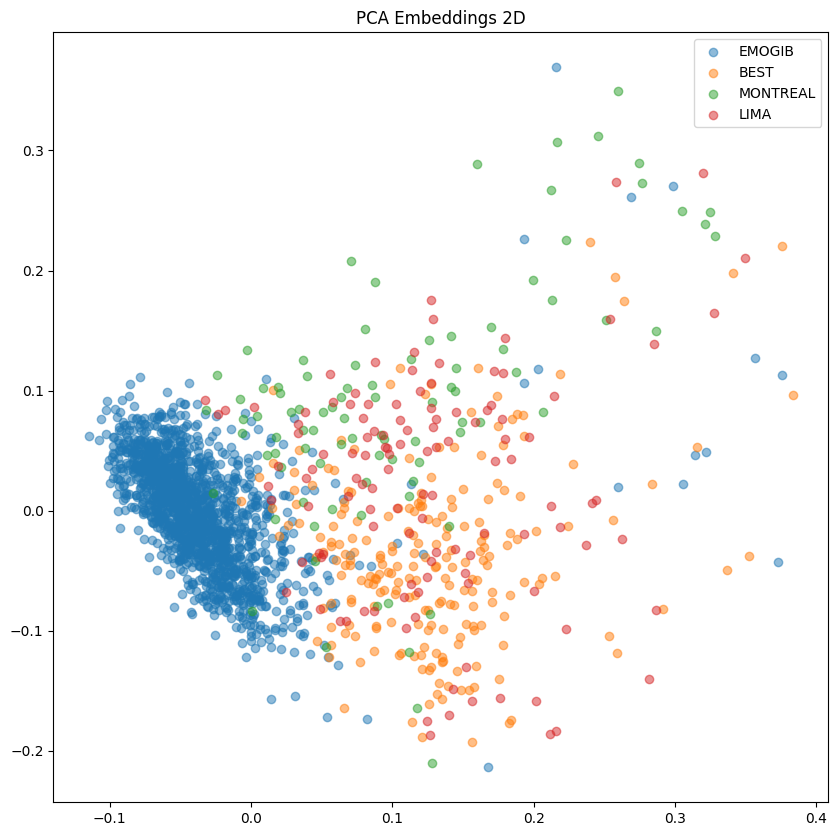

In [10]:
# plot the 2d pca projections
plt.figure(figsize=(10, 10))
for i, (source) in enumerate(df['source'].unique()):
    idx = df['source'] == source
    plt.scatter(pca_projections_2d[idx, 0], pca_projections_2d[idx, 1], label=source, alpha=0.5)

plt.legend()
plt.title('PCA Embeddings 2D')
plt.show()

In [11]:
# plot the 3d pca projections using plotly
import plotly.express as px

# get the colors distict for each speaker
fig = px.scatter_3d(x=pca_projections_3d[:, 0], y=pca_projections_3d[:, 1], z=pca_projections_3d[:, 2], color=df['source'])
fig.update_layout(title='PCA Embeddings 3D')
fig.show()


### Visualise with t-SNE

In [12]:
# visualise using t-SNE
from sklearn.manifold import TSNE

tsne_2d = TSNE(n_components=2, perplexity=30, n_iter=300) # reduce into 3d dimension
# tsne_projections = tsne.fit_transform(np.stack(df['embed_vector']))
tsne_projections_2d = tsne_2d.fit_transform(embed_vectors)


tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=300) # reduce into 3d dimension
tsne_projections_3d = tsne_3d.fit_transform(embed_vectors)

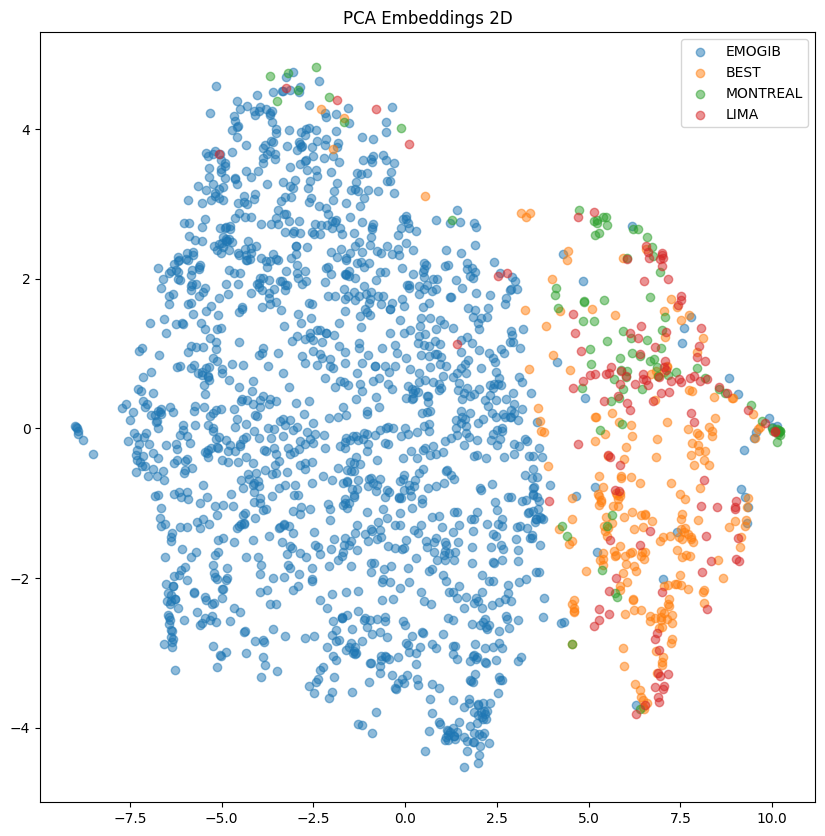

In [13]:
# plot the 2d t-sne projections
plt.figure(figsize=(10, 10))
for i, (source) in enumerate(df['source'].unique()):
    idx = df['source'] == source
    plt.scatter(tsne_projections_2d[idx, 0], tsne_projections_2d[idx, 1], label=source, alpha=0.5)

plt.legend()
plt.title('PCA Embeddings 2D')
plt.show()

In [15]:
# plot in 3d with plotly
import plotly.express as px
# import plotly.graph_objects as go
import plotly.express as px

fig = px.scatter_3d(x=tsne_projections_3d[:, 0], y=tsne_projections_3d[:, 1], z=tsne_projections_3d[:, 2], color=df['source'])
fig.update_layout(title='t-SNE Embeddings 3D')
fig.show()


### Visualise with UMAP

In [4]:
import umap.umap_ as umap

umap_2d = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
umap_projections_2d = umap_2d.fit_transform(embed_vectors)

umap_3d = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1)
umap_projections_3d = umap_3d.fit_transform(embed_vectors)

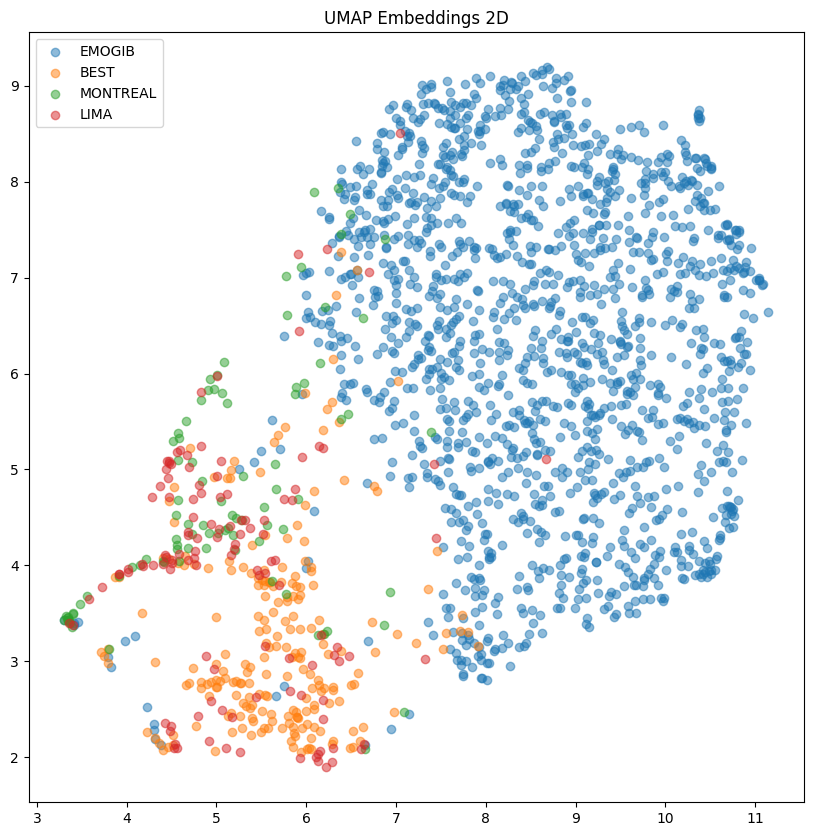

In [17]:
# plot the embeddings
plt.figure(figsize=(10, 10))
for i, (source) in enumerate(df['source'].unique()):
    idx = df['source'] == source
    plt.scatter(umap_projections_2d[idx, 0], umap_projections_2d[idx, 1], label=source, alpha=0.5)

plt.legend()
plt.title('UMAP Embeddings 2D')
plt.show()

In [5]:
import plotly.express as px

fig = px.scatter(x=umap_projections_2d[:, 0], y=umap_projections_3d[:, 1], color=df['source'])
fig.update_layout(title='UMAP Embeddings 2D - Source')
fig.show()

In [18]:
# plot in 3d with plotly
import plotly.express as px

fig = px.scatter_3d(x=umap_projections_3d[:, 0], y=umap_projections_3d[:, 1], z=umap_projections_3d[:, 2], color=df['source'])
fig.update_layout(title='UMAP Embeddings 3D - Source')
fig.show()

### Conclusion

Based on the vector embeddings, we can distinguish between different robot voices, in this case, EMOGIB and BEST (even for the NASNAT and NASVOC of EMOGIB) However, the efficient of speaker verification for BEST robot voice can not distinguisable with 2 other humna voices, MONTREAL and LIMA.

ANYTHING RELATED TO ROBOTICNESS ??

### Further seperate clusters by emotion

In [9]:
df_embedded_vectors = pd.read_csv('embedded_vectors/final_embedded_vectors.csv')

In [10]:
# selecting only BEST and MONTREAL data
df_best_montreal = df_embedded_vectors[(df_embedded_vectors['source'] == 'BEST') | (df_embedded_vectors['source'] == 'MONTREAL')]

df_best_montreal.loc[:, 'embeded_vector'] = df_best_montreal['embeded_vector'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))

# get the embeded vectors
embed_vectors_best_montreal = np.stack(df_best_montreal['embeded_vector'].values) # using this embedded vectors to find the intersection between BEST and MONTREAL

In [11]:
umap_3d = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1)
umap_best_montreal_3d = umap_3d.fit_transform(embed_vectors_best_montreal)

In [13]:
# plot in 3d with plotly
import plotly.express as px

fig = px.scatter_3d(x=umap_best_montreal_3d[:, 0], y=umap_best_montreal_3d[:, 1], z=umap_best_montreal_3d[:, 2], color=df_best_montreal['source'])
fig.update_layout(title='UMAP Embeddings 3D - Source')
fig.show()

In [ ]:
# get the intersection between BEST and MONTREAL
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(embed_vectors_best_montreal)

# get all the file where the cosine similarity is greater than 0.9
similar_files = []
for i in range(cosine_sim.shape[0]):
    for j in range(i+1, cosine_sim.shape[1]):
        if cosine_sim[i, j] > 0.9:
            similar_files.append((df_best_montreal.iloc[i]['filename'], df_best_montreal.iloc[j]['filename']))

similar_files



### Check the emotion labels of all sources

In [23]:
# EMOGIB unique emotions
# df['emotion'].unique()

df_emogib_emotions = df[df['source'] == 'EMOGIB']['emotion'].unique()
print(f"EMOGIB unique emotions: {df_emogib_emotions}")

df_best_emotions = df[df['source'] == 'BEST']['emotion'].unique()
print(f"BEST unique emotions: {df_emogib_emotions}")

df_lima_emotions = df[df['source'] == 'LIMA']['emotion'].unique()
print(f"LIMA unique emotions: {df_lima_emotions}")

df_montreal_emotions = df[df['source'] == 'MONTREAL']['emotion'].unique()
print(f"MONTREAL unique emotions: {df_montreal_emotions}")

EMOGIB unique emotions: ['anger' 'disgust' 'fear' 'happiness' 'neutral' 'sadness' 'surprise']
BEST unique emotions: ['anger' 'disgust' 'fear' 'happiness' 'neutral' 'sadness' 'surprise']
LIMA unique emotions: ['achievement' 'amusement' 'anger' 'disgust' 'fear' 'pleasure' 'relief'
 'sadness']
MONTREAL unique emotions: ['anger' 'disgust' 'fear' 'happiness' 'neutral' 'pain' 'pleasure'
 'sadness' 'surprise']


EMOGIB and BEST have the same emotions labels, so we can use it to classify by emotion

### Emotion classification for robot voice

In [24]:
df_robot = df[df['category'] == 'robot']
df_robot.head()

,filename,embeded_vector,source,speaker_id,emotion,audio_type,category
0,EMOGIB_001_anger_NSNAT,"[0.03846552, 0.05775534, 0.03635062, -0.006747...",EMOGIB,1,anger,NSNAT,robot
1,EMOGIB_001_anger_NSVOC,"[0.0441835672, 0.0611051545, 0.0281773023, -0....",EMOGIB,1,anger,NSVOC,robot
2,EMOGIB_001_disgust_NSNAT,"[0.0579037, 0.06654421, 0.03760731, -0.0192567...",EMOGIB,1,disgust,NSNAT,robot
3,EMOGIB_001_disgust_NSVOC,"[0.0492570214, 0.0745674893, 0.0301841609, -0....",EMOGIB,1,disgust,NSVOC,robot
4,EMOGIB_001_fear_NSNAT,"[0.04453431, 0.06850263, 0.03906401, -0.009056...",EMOGIB,1,fear,NSNAT,robot


In [26]:
embed_vectors_robot = np.stack(df_robot['embeded_vector'].values)

In [27]:
import umap.umap_ as umap

umap_2d = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
umap_robot_projections_2d = umap_2d.fit_transform(embed_vectors_robot)

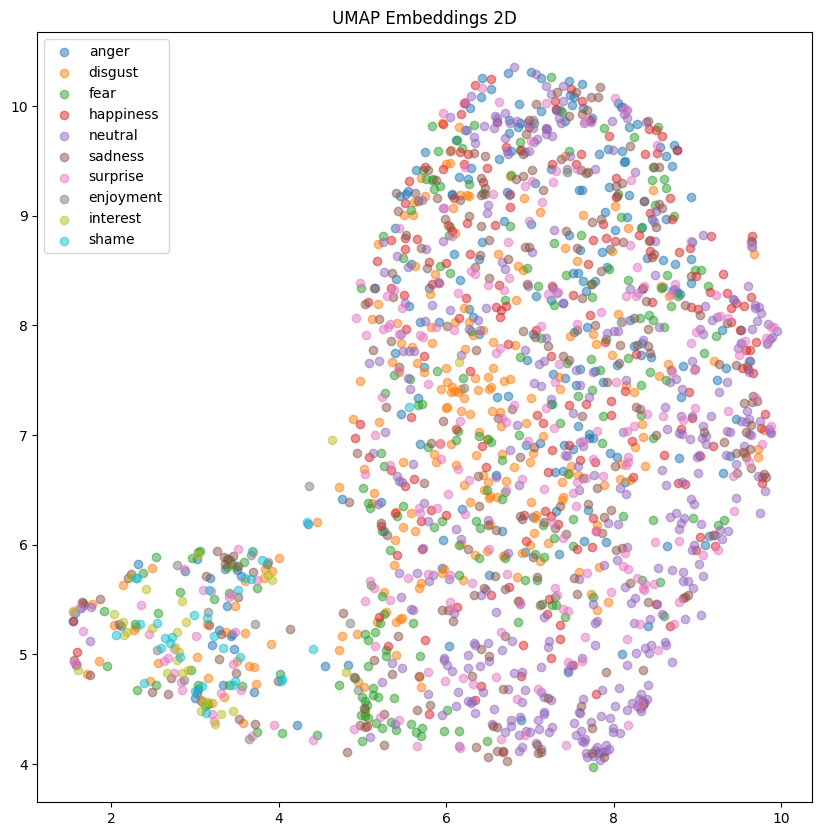

In [29]:
# plot the embeddings
plt.figure(figsize=(10, 10))
for i, (emotion) in enumerate(df_robot['emotion'].unique()):
    idx = df_robot['emotion'] == emotion
    plt.scatter(umap_robot_projections_2d[idx, 0], umap_robot_projections_2d[idx, 1], label=emotion, alpha=0.5)

plt.legend()
plt.title('UMAP Embeddings 2D')
plt.show()

### Conclusion

Not possible to distinguish between robot emotions, so the classification by emotion in robot voices is not possible

## Analysing the emotion in Montreal data

In [ ]:
# matching the speaker with the reduced dimension
df['umap_2d_x'] = umap_projections_2d[:, 0]

df['umap_2d_y'] = umap_projections_2d[:, 1]
df['pca_2d_x'] = pca_projections_2d[:, 0]
df['pca_2d_y'] = pca_projections_2d[:, 1]
df['tsne_2d_x'] = tsne_projections_2d[:, 0]
df['tsne_2d_y'] = tsne_projections_2d[:, 1]

df.head()


In [ ]:
# Since happiness and sadness are in the same cluster, we want to see the cluster of other part, so we will remove the happy and sad emotion

df_not_happy_sad = df[(df['emotion'] != 'happiness') & (df['emotion'] != 'sadness')]

df_not_happy_sad.head()

In [ ]:
# calculate umap for the new dataframe
umap_2d = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
umap_projections_2d = umap_2d.fit_transform(np.stack(df_not_happy_sad['embed_vector']))

df_not_happy_sad['umap_2d_x'] = umap_projections_2d[:, 0]
df_not_happy_sad['umap_2d_y'] = umap_projections_2d[:, 1]

# plot the embeddings
plt.figure(figsize=(10, 10))
for i, (emotion) in enumerate(df_not_happy_sad['emotion'].unique()):
    idx = df_not_happy_sad['emotion'] == emotion
    plt.scatter(umap_projections_2d[idx, 0], umap_projections_2d[idx, 1], label=emotion, alpha=0.5)

plt.legend()
plt.title('UMAP Embeddings 2D (Excl. Happy and Sad)')
plt.show()


In this observation, now a new cluster can be observe is the seperate in `neutral` and `pleasure`

In [ ]:
# plot the embeddings
plt.figure(figsize=(10, 10))
for i, (sp_id) in enumerate(df['sp_id'].unique()):
    idx = df['sp_id'] == sp_id
    plt.scatter(tsne_projections_2d[idx, 0], tsne_projections_2d[idx, 1], label=sp_id, alpha=0.5)

plt.legend()
plt.title('t-SNE Embeddings 2D')
plt.show()


In [ ]:
# plot the 2d pca projections
plt.figure(figsize=(10, 10))
for i, (sp_id) in enumerate(df['sp_id'].unique()):
    idx = df['sp_id'] == sp_id
    plt.scatter(pca_projections_2d[idx, 0], pca_projections_2d[idx, 1], label=sp_id, alpha=0.5)

plt.legend()
plt.title('PCA Embeddings 2D')
plt.show()